# Project Titanic Survival Prediction

In [62]:
import numpy as np
import pandas as pd 
import pickle
import os

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [63]:
titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [64]:
titanic.dtypes

survived          int64
pclass            int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
embarked         object
class          category
who              object
adult_male         bool
deck           category
embark_town      object
alive            object
alone              bool
dtype: object

In [65]:
titanic.isnull().sum()


survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

#### Features to drop
`deck` has a lot of missing values so we'll drop it. `age` has a few missing values as well. Although it could be, `embarked` and `embark_town` don't seem relevant so we'll drop them as well. It's unclear what `alive` refers to so we'll ignore it.
#### Target
`survived` is our target class variable.


In [66]:
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'class', 'who', 'adult_male', 'alone']
target = 'survived'

x = titanic[features]
y = titanic[target]

### How balanced are the classes?


In [67]:
y.value_counts()

survived
0    549
1    342
Name: count, dtype: int64

### Split the data into training and testing sets

In [68]:

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

### Define preprocessing transformers for numerical and categorical features
#### Automatically detect numerical and categorical columns and assign them to separate numeric and categorical features

In [ ]:
numerical_features = x_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = x_train.select_dtypes(include=['object','category']).columns.tolist()
print(numerical_features)
print(categorical_features)

['pclass', 'age', 'sibsp', 'parch', 'fare']
['sex', 'class', 'who']


#### Define separate preprocessing pipelines for both feature types



In [70]:
numerical_transformer = Pipeline(steps=[
    ('impute',SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('impute',SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',drop='first'))
])


#### Combine the transformers into a single column transformer



In [71]:
preprocessor = ColumnTransformer(transformers=[
    ('num',numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

### Create a model pipeline
Now let's complete the model pipeline by combining the preprocessing with a Random Forest classifier


In [72]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',RandomForestClassifier(random_state=42))
])

### Define a parameter grid 
We'll use the grid in a cross validation search to optimize the model


In [73]:
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth':[None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

### Perform grid search cross-validation and fit the best model to the training data


In [74]:
cv = StratifiedKFold(n_splits=5, shuffle=True)


### Train the pipeline model 


In [75]:
rf_pipeline = GridSearchCV(estimator=pipeline, param_grid= param_grid, cv=cv, scoring='accuracy', verbose=2 )
rf_pipeline.fit(x_train, y_train)



Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__max_depth': [None, 10, ...], 'classifier__min_samples_split': [2, 5], 'classifier__n_estimators': [50, 100]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [76]:
os.makedirs('models', exist_ok=True)

with open('models/model_rf.pkl', 'wb') as model_file:
    pickle.dump(rf_pipeline, model_file)
print("Random Forest model trained and saved.")

Random Forest model trained and saved.


### Get the model predictions from the grid search estimator on the unseen data
Also print a classification report


In [77]:
y_pred = rf_pipeline.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       110
           1       0.78      0.72      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



### Plot the confusion matrix 

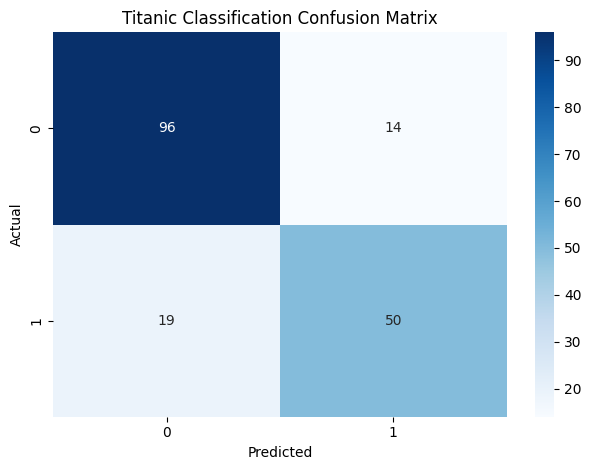

In [78]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## Feature importances

In [79]:
rf_pipeline.best_estimator_['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

array(['sex_male', 'class_Second', 'class_Third', 'who_man', 'who_woman'],
      dtype=object)

In [80]:
feature_importances = rf_pipeline.best_estimator_['classifier'].feature_importances_

# Combine the numerical and one-hot encoded categorical feature names
feature_names = numerical_features + list(rf_pipeline.best_estimator_['preprocessor']
                                        .named_transformers_['cat']
                                        .named_steps['onehot']
                                        .get_feature_names_out(categorical_features))

### Display the feature importances in a bar plot


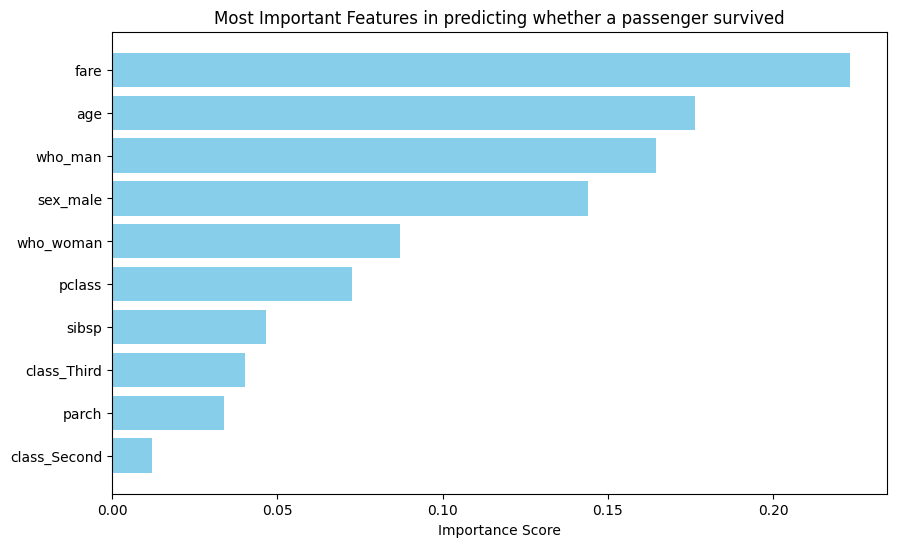


Test set accuracy: 81.56%


In [81]:
df = pd.DataFrame({'Feature': feature_names,
                   'Importance': feature_importances
                             }).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(df['Feature'], df['Importance'], color='skyblue')
plt.gca().invert_yaxis() 
plt.title('Most Important Features in predicting whether a passenger survived')
plt.xlabel('Importance Score')
plt.show()

test_score = rf_pipeline.score(x_test, y_test)
print(f"\nTest set accuracy: {test_score:.2%}")

# Try another model


In [82]:
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

lr_param_grid = {
    'classifier__solver' : ['liblinear'],  
    'classifier__penalty': ['l1', 'l2'],  
    'classifier__class_weight' : [None, 'balanced']  
}

lr_grid_search = GridSearchCV(lr_pipeline, param_grid=lr_param_grid, cv=5, scoring='accuracy', verbose=2)

lr_grid_search.fit(x_train, y_train)
y_pred = lr_grid_search.predict(x_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=No

### Display the clasification report for the new model 


In [83]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       110
           1       0.81      0.72      0.76        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.82       179



### Display the confusion matrix for the new model 


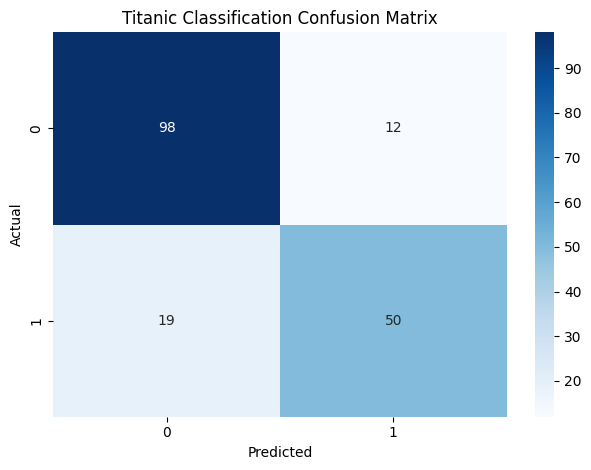

In [84]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

### Extract the logistic regression feature coefficients and plot their magnitude in a bar chart.


In [85]:
coefficients = lr_grid_search.best_estimator_.named_steps['classifier'].coef_[0]

numerical_feature_names = numerical_features
categorical_feature_names = (lr_grid_search.best_estimator_.named_steps['preprocessor']
                                     .named_transformers_['cat']
                                     .named_steps['onehot']
                                     .get_feature_names_out(categorical_features)
                            )
feature_names = numerical_feature_names + list(categorical_feature_names)

### Plot the feature coefficient magnitudes in a bar chart


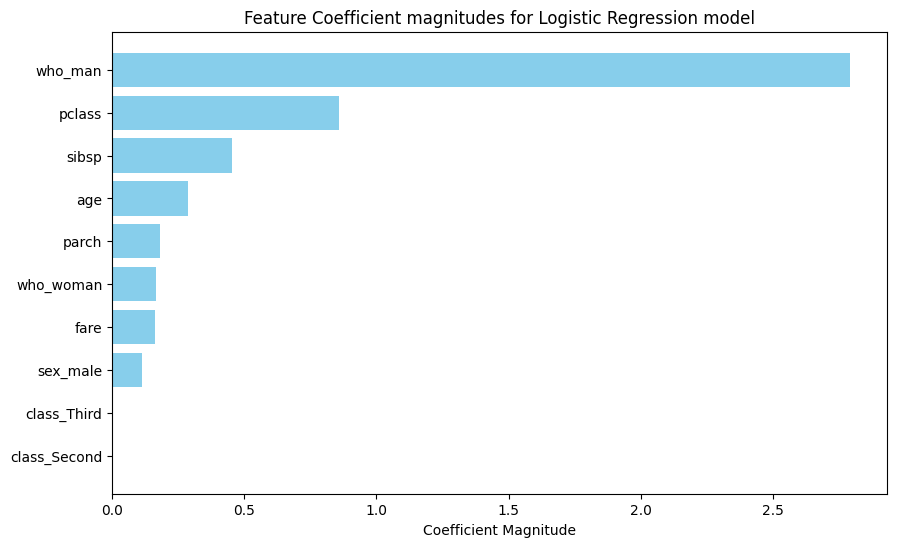


Test set accuracy: 82.68%


In [86]:
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False, key=abs)  

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Coefficient'].abs(), color='skyblue')
plt.gca().invert_yaxis()
plt.title('Feature Coefficient magnitudes for Logistic Regression model')
plt.xlabel('Coefficient Magnitude')
plt.show()


test_score = lr_grid_search.best_estimator_.score(x_test, y_test)
print(f"\nTest set accuracy: {test_score:.2%}")

In [87]:
titanic.to_csv('titanic_dataset.csv', index=False)

In [88]:
os.makedirs('models', exist_ok=True)

with open('models/model_lr.pkl', 'wb') as lr_model_file:
    pickle.dump(lr_grid_search.best_estimator_, lr_model_file)

print("Logistic Regression model trained and saved as model_lr.pkl")

Logistic Regression model trained and saved as model_lr.pkl


In [89]:
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('lr', LogisticRegression(random_state=42))
], voting='hard')

voting_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', voting_model)
])

voting_pipeline.fit(x_train, y_train)

with open('models/model_voting.pkl', 'wb') as model_file:
    pickle.dump(voting_pipeline, model_file)
print("Voting Classifier model trained and saved.")


Voting Classifier model trained and saved.


In [92]:
voting_score = voting_pipeline.score(x_test, y_test)
print(f"Voting Classifier Test Accuracy: {voting_score * 100:.2f}%")

Voting Classifier Test Accuracy: 82.12%
